#### Imports 

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

#### Importing Data

In [26]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [27]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [28]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [29]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [30]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


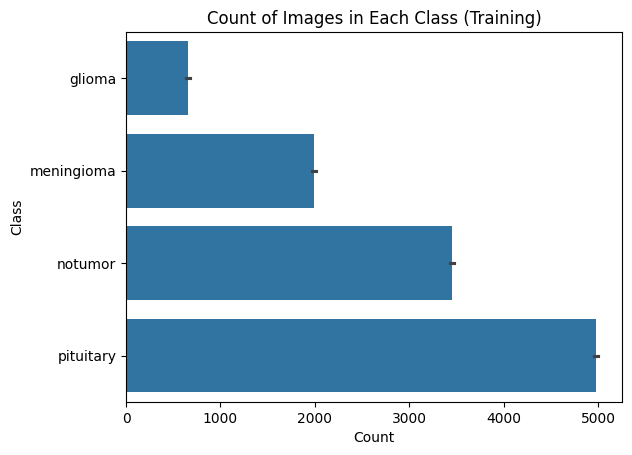

In [31]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

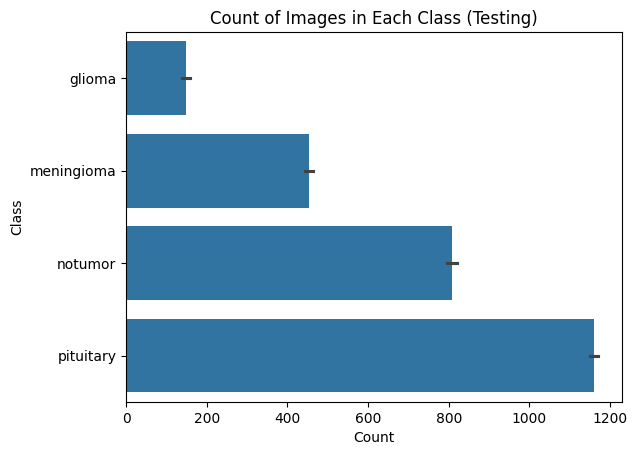

In [32]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

#### Data Preprocessing

In [33]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=True)

# set shuffle equal to True simply for the picture

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [34]:
# Use annomoly detection, the notumor images to the tumor images. Could tell us where the tumor is.

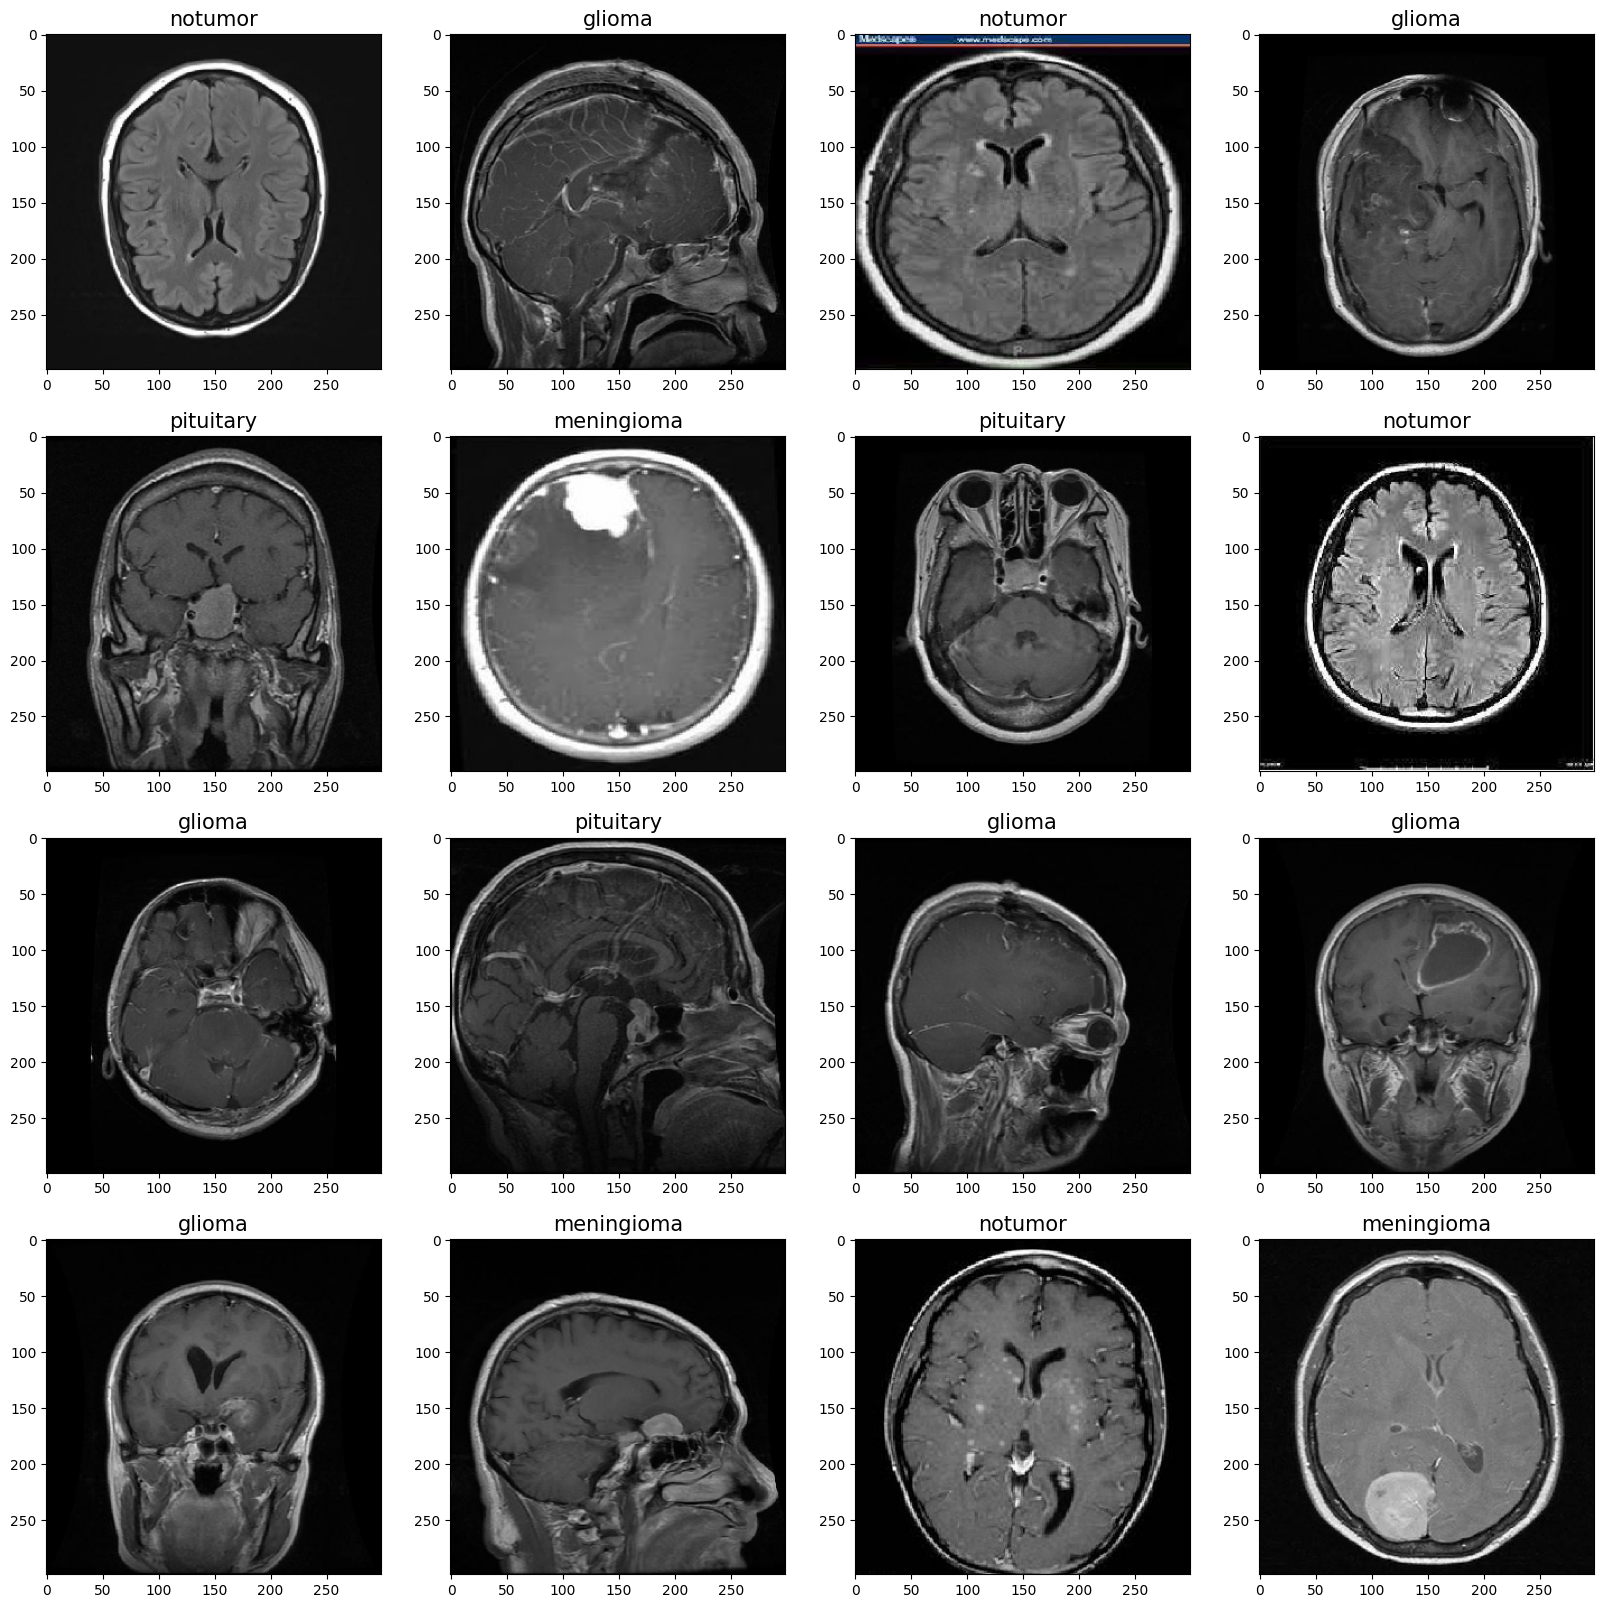

In [35]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

In [36]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size,
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

# set shuffle back to false for model and confusion matrix 
# if set to true, then messes up confusion matrix as true labels 
# are also shuffled with the images. 

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [37]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

#### Initial CNN

In [38]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - accuracy: 0.6921 - loss: 2.1061
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.8978 - loss: 0.2899
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.9582 - loss: 0.1309
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - accuracy: 0.9835 - loss: 0.0642
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - accuracy: 0.9935 - loss: 0.0337
82/82 - 5s - 61ms/step - accuracy: 0.9352 - loss: 0.1995
Loss: 0.1995021551847458
Accuracy: 0.9351639747619629


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


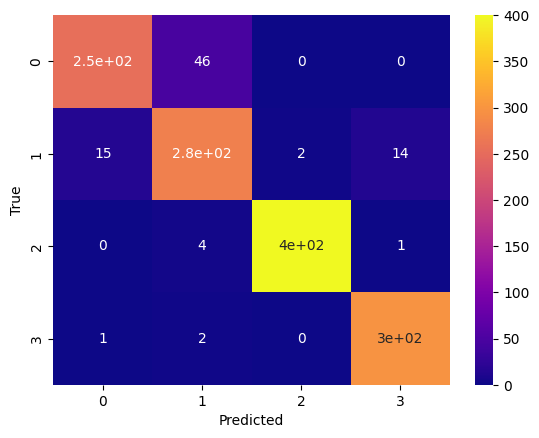

              precision    recall  f1-score   support

      glioma       0.94      0.85      0.89       300
  meningioma       0.84      0.90      0.87       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



In [39]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Hyperparameter Tuning

In [40]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 118s 654ms/step - accuracy: 0.7334 - loss: 1.7843
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 118s 658ms/step - accuracy: 0.9202 - loss: 0.2203
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 670ms/step - accuracy: 0.9788 - loss: 0.0793
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 644ms/step - accuracy: 0.9914 - loss: 0.0366
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 664ms/step - accuracy: 0.9988 - loss: 0.0121
82/82 - 10s - 123ms/step - accuracy: 0.9504 - loss: 0.1760
Loss: 0.17597368359565735
Accuracy: 0.950419545173645


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step


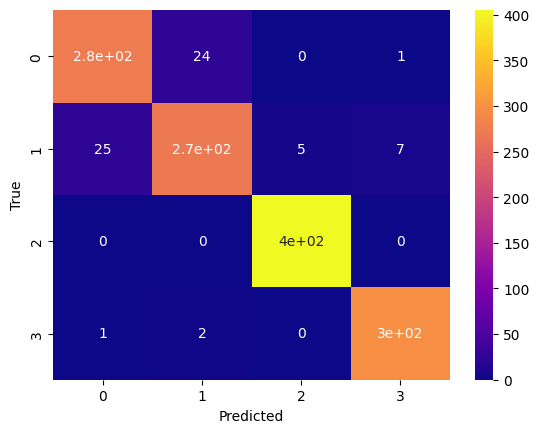

              precision    recall  f1-score   support

      glioma       0.91      0.92      0.92       300
  meningioma       0.91      0.88      0.90       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [41]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Anomaly Dectection Using Isolation Forests

In [46]:
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=-2).output 
    # index=-2 gives Dense(64) layer
)

# building feature extractor from trained CNN

In [45]:
model.inputs

[<KerasTensor shape=(None, 299, 299, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_61>]

In [62]:
print(tr_gen.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [63]:
normal_class_index 

2

In [89]:
# Extract features from all Normal training images
normal_class_index = tr_gen.class_indices["notumor"]

normal_features = []

for x, y in tr_gen:
    normal_indices = np.where(np.argmax(y, axis=1) == normal_class_index)[0]
    print(normal_indices)
    if len(normal_indices) == 0:
        continue

    imgs = x[normal_indices]
    feats = feature_extractor.predict(imgs)
    normal_features.append(feats)

    if len(normal_features) * tr_gen.batch_size >= tr_gen.n:
        break

normal_features = np.vstack(normal_features)
print("Feature Shape:", normal_features.shape)


[ 0 10 11 16 20 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[ 0  5  6 13 19 22 23 25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[ 1  5 10 12 18 20 29 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
[ 2  7 10 15 16 17 22 27 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[ 0  2  6 12 13 22 26 29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[ 1  2  5  6  8 15 17 21 22 27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
[ 5  6  7 12 15 25 26 29 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
[ 3  4  5 12 13 15 19 20 21 22 24 29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
[ 0  9 12 13 15 17 23 24 27 29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
[ 1  3  4  9 11 14 20 23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
[ 3 16 20 21 22 24 26 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
[ 3 10 11 20 22 27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[ 1  3  5  6  8 11 16 17 24 27 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
[ 4  7  8 17 19 21 23 27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[ 1  7 10 16 21 25 26 27 28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140

In [91]:
# Train the Isolation Forest

from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination = 0.5, # percentage of anomalies 
    random_state=42
)

iso.fit(normal_features)

,n_estimators,100
,max_samples,'auto'
,contamination,0.5
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [92]:
# Use it to detext anomalies on any image

def anomaly_score(img):

    feat = feature_extractor.predict(img[None,...])
    score = -iso.decision_function(feat)[0] # higher = more anomalous
    label = iso.predict(feat)[0]            # -1 = anomaly, 1 = normal
    return score, label

In [95]:
for i, (image,tum) in enumerate(zip(images, labels)):
    print(label)
    score, label = anomaly_score(image)
    new_label = np.where(tum==1)[0][0]
    if label == -1 and new_label != 2:
        print("Correct Tumor")
    elif label == -1 and new_label == 2:
        print("Incorrect Tumor")
    elif label == 1 and new_label != 2:
        print("Incorrect Okie Dokie")
    elif label == 1 and new_label == 2:
        print("Correct Okie Dokie")
    #plt.subplot(4,4, i+1)
    #plt.imshow(image)
    #class_name = classes[np.argmax(label)]
    #plt.title(class_name, color="k", fontsize=15)
#plt.show()

-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Correct Okie Dokie
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Correct Okie Dokie
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Correct Okie Dokie
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Incorrect Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Correct Tumor
-1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Correct Tu

KeyboardInterrupt: 

In [69]:
images, labels = next(ts_gen)

batch_index = ts_gen.batch_index - 1
start = batch_index * ts_gen.batch_size
end = start + len(images)
batch_filenames = ts_gen.filenames[:]

print(start,end)

i = 1

for img, fname in zip(images, batch_filenames):
    print(i)
    i+=1
    score, pred = anomaly_score(img)

    if pred == -1:
        print("Anomaly:", fname, "Score:", score)
    else:
        print("Normal:", fname, "Score:", score)

80 96
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Normal: Data\Testing\glioma\Te-glTr_0000.jpg Score: -0.28834576896479247
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Normal: Data\Testing\glioma\Te-glTr_0001.jpg Score: -0.3071805459090475
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Normal: Data\Testing\glioma\Te-glTr_0002.jpg Score: -0.26047126262267534
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Normal: Data\Testing\glioma\Te-glTr_0003.jpg Score: -0.26424682466273697
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Normal: Data\Testing\glioma\Te-glTr_0004.jpg Score: -0.2851006312599689
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Normal: Data\Testing\glioma\Te-glTr_0005.jpg Score: -0.30364363300499697
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Normal: Data\Testing\glioma\Te-glTr_0006.jpg Score: -0.2892924851000134
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Normal: Data\Testing\glioma\Te-glTr_0007.jpg Score: -0.2649914931970184
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Normal: Data\Testing\glioma\Te-glTr_0008.jpg Score: -0

In [79]:
ts_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    target_size=img_size, 
                                    batch_size=len(ts_df),
                                    shuffle=True)
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    #plt.subplot(4,4, i+1)
    #plt.imshow(image)
    #class_name = classes[np.argmax(label)]
    #plt.title(class_name, color="k", fontsize=15)
#plt.show()
    score, pred = anomaly_score(image)
    class_name = classes[np.argmax(label)]
    print(pred)
    if pred == -1:
        print("Anomaly:", class_name, "Score:", score)
    #else:
    #    print("Normal:", class_name, "Score:", score)

Found 1311 validated image filenames belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1
1/1 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 

<Figure size 2000x2000 with 0 Axes>

#### Anonaly Detection, autoencoders. 

In [18]:
laten_dim = 64

encoder = models.Sequential([
    layers.Conv2D(64, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.Conv2D(16, (3,3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(laten_dim*2)
], name="encoder")

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
class Sampling(layers.Layer):
    def call(self, z_params):
        
        z_mean, z_log_var = tf.split(z_params, 2, axis=1)
        # The endoder outputs (z_mean, z_log_var) stacked together,
        # this line splits them into two tensors

        eps = tf.random.normal(shape=tf.shape(z_mean))
        # Generate random noise with the same shape as z_mean
        
        return z_mean + tf.exp(0.5 * z_log_var) * eps
        # This is the reparameterization trick:
        #  - tf.exp = standard deviation
        #  - muttiply by noise to introduce randomness
        #  - add mean to shift the distribution
    
"""
Reparameterization trick is required to make the VAE trainable. 

It takes the encoder's output [z_mean, z_log_var], and uses them 
 to produce a vector to be fed into the decoder 

This needs to be done becasue VAE learns distribution, not a single point,
 the model then samples a point from this distribution

Sampling is not differentiable, and since NNs train on gradients, we need
 to rewrite the sampling in a differentiable way (z= mean + std * eps)

"""

"\nReparameterization trick is required to make the VAE trainable. \n\nIt takes the encoder's output [z_mean, z_log_var], and uses them \n to produce a vector to be fed into the decoder \n\nThis needs to be done becasue VAE learns distribution, not a single point,\n the model then samples a point from this distribution\n\nSampling is not differentiable, and since NNs train on gradients, we need\n to rewrite the sampling in a differentiable way (z= mean + std * eps)\n\n"

In [20]:
# decoder = models.Sequential([
#     layers.Dense(294*294*64, activation="relu", input_shape=(laten_dim,)),
#     layers.Reshape((294, 294, 64)),
#     layers.Conv2DTranspose(64, 2, activation="relu"),
#     layers.Conv2DTranspose(32, 2, activation="relu"),
#     layers.Conv2DTranspose(16, 2, activation="relu"),
#     layers.Conv2DTranspose(3, 3, activation="sigmoid"),
# ], name="decoder")

In [21]:
decoder = models.Sequential([
    layers.Dense(19*19*64, activation="relu", input_shape=(laten_dim,)),
    layers.Reshape((19,19,64)),
    layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2D(3, 3, padding="same", activation="sigmoid"),
    layers.Cropping2D(((2,3), (2,3))),
], name="decoder")

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampling()

        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    
    def train_step(self, data):
        
        x, _ = data

        self.beta.assign(tf.minimum(1.0, self.beta + 0.001))

        with tf.GradientTape() as tape:
            z_params = self.encoder(x)
            z_mean, z_log_var = tf.split(z_params, 2, axis=1)

            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)

            z_params_clipped = tf.concat([z_mean, z_log_var], axis=1)

            z = self.sampler(z_params_clipped)

            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(tf.square(x -reconstruction))
            recon_loss = tf.reduce_sum(recon_loss, axis=list(range(1, len(recon_loss.shape))))
            recon_loss = tf.reduce_mean(tf.reduce_sum(recon_loss))

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            #beta = 0.1

            total_loss = recon_loss + self.beta * kl_loss
    
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss,
                "reconstruction_loss": recon_loss,
                "kl_loss": kl_loss
                }

In [24]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(tr_gen, epochs=1, batch_size=64)
vae.predict(ts_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - kl_loss: 2.3454e-05 - loss: 0.0254 - reconstruction_loss: 0.0254


NotImplementedError: Exception encountered when calling VAE.call().

[1mModel VAE does not have a `call()` method implemented.[0m

Arguments received by VAE.call():
  • args=('tf.Tensor(shape=(16, 299, 299, 3), dtype=float32)',)
  • kwargs=<class 'inspect._empty'>

The mse loss is alright, but the kl_loss is being collapsed down to zero, nmeaning that it's getting overshadowed by the reconstruction loss, fix that by giving it a weight. Also, change the latent_dim to something bigger, maybe 16 or 32? the 2-dim sapce is too small for the images to actually learn something. 